In [227]:
library("brms")
library("dplyr")
library("bayesplot")
library("rstanarm")
library("ggplot2")
library("rstan")
library("tidyr")
library("ggpubr")
library("projpred")
library("corrplot")
library("loo")
library("tidyverse")
library("here")
library("knitr")
library("walker")
library("tidybayes")
library("broom")
library("ggridges")
library("cmdstanr")
library("reshape2")
library("lubridate")
library("hrbrthemes")
library("viridis")
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=12)
options(warn=-1)
#https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#using-or-publishing-our-price-paid-data
#     Postcode
#     PAON Primary Addressable Object Name. Typically the house number or name.
#     SAON Secondary Addressable Object Name. If there is a sub-building, for example, the building is divided into flats, there will be a SAON.
#     Street
#     Locality
#     Town/City
#     District
#     County

set_cmdstan_path("/Users/thomasmellan/Documents/cmdstan/")
path <- "/Users/thomasmellan/Documents/houseprices/"
df_hp_original <- read.csv(paste0(path,"pp-2020.csv"))

CmdStan path set to: /Users/thomasmellan/Documents/cmdstan



In [228]:
df_hp <- df_hp_original
df_hp <- na.omit(df_hp)
colnames(df_hp) <- c("POAN","PricePaid","Date","Postcode",
                     "c1","c2","c3",
                     "a1","a2","a3","a4","a5","a6","a7",
                     "u1","u2")
df_hp$Date <- ymd(as.Date(df_hp$Date))

In [229]:
minPrice <- 100000  #100g
maxPrice <- 1000000 #1mil
df_hp <- df_hp[df_hp$PricePaid > minPrice & df_hp$PricePaid < maxPrice,]

df_hp$PricePaidGroup <- cut(df_hp$PricePaid, c(100000,250000,500000,1000000,2000000,5000000), include.lowest = TRUE)

df.ldn <- df_hp[df_hp$a5 == "LONDON",]

df.ldn$Month <- as.factor(month(df.ldn$Date))
df.ldn.tmp <- df.ldn[c("PricePaid","Month","PricePaidGroup")]

summary(df.ldn[c("PricePaid","Date","PricePaidGroup")])

   PricePaid           Date                    PricePaidGroup 
 Min.   :100500   Min.   :2020-01-02   [1e+05,2.5e+05]: 1594  
 1st Qu.:362581   1st Qu.:2020-02-19   (2.5e+05,5e+05]:10534  
 Median :479950   Median :2020-04-03   (5e+05,1e+06]  : 9696  
 Mean   :509966   Mean   :2020-04-27   (1e+06,2e+06]  :    0  
 3rd Qu.:640000   3rd Qu.:2020-07-10   (2e+06,5e+06]  :    0  
 Max.   :999999   Max.   :2020-10-23                          

In [230]:
df.ldn.tmp$"Month" <- as.numeric(df.ldn.tmp$"Month")
df.ldn.tmp$"PricePaid" <- df.ldn.tmp$"PricePaid"/1000000
head(df.ldn.tmp)

,PricePaid,Month,PricePaidGroup
,<dbl>,<dbl>,<fct>
867,0.71000,7,"(5e+05,1e+06]"
870,0.34000,7,"(2.5e+05,5e+05]"
871,0.19265,7,"[1e+05,2.5e+05]"
872,0.92000,5,"(5e+05,1e+06]"
875,0.47900,7,"(2.5e+05,5e+05]"
876,0.35500,7,"(2.5e+05,5e+05]"


In [231]:
get_prior(PricePaid ~ s(Month, by = PricePaidGroup) + (1|PricePaidGroup),
    data = df.ldn.tmp)

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,sMonth:PricePaidGroup1eP052.5eP05_1,,,,,,default
,b,sMonth:PricePaidGroup2.5eP055eP05_1,,,,,,default
,b,sMonth:PricePaidGroup5eP051eP06_1,,,,,,default
"student_t(3, 0.5, 2.5)",Intercept,,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,,default
,sd,,PricePaidGroup,,,,,default
,sd,Intercept,PricePaidGroup,,,,,default
"student_t(3, 0, 2.5)",sds,,,,,,,default


In [232]:
# hist(rgamma(1000,shape = 1, scale = 1))
priors <- c(prior(normal(1,0.5), class = "Intercept"),
            prior(normal(0,0.25), class = "b"))
fit2 <- brm(
    PricePaid ~ s(Month, by = PricePaidGroup) + (1|PricePaidGroup),
    data = df.ldn.tmp, 
    prior = priors,
    family = Gamma,
    iter=1000,
    chains = 2,
    cores = 2,
    seed = 123,
    control = list(adapt_delta = 0.9),
    backend = 'cmdstanr',
    refresh = 0
)

Compiling Stan program...

Start sampling



Running MCMC with 2 parallel chains...



Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: gamma_lpdf: Inverse scale parameter[1] is -8.13889, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/RtmpC2mCpf/model-2a617a9f1f53.stan', line 83, column 4 to column 40)

Chain 1 Exception: gamma_lpdf: Inverse scale parameter[1] is -8.13889, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/RtmpC2mCpf/model-2a617a9f1f53.stan', line 83, column 4 to column 40)

Chain 2 Rejecting initial value:

Chain 2   Error evaluating the log probability at the initial value.

Chain 2 Exception: gamma_lpdf: Inverse scale parameter[1] is -0.0710862, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/RtmpC2mCpf/model-2a617a9f1f53.stan', line 83, column 4 to column 40)

Chain 2 Exception: gamma_lpdf: Inverse scale parameter[1] is -0.0710862, but must be positive finite! (in '/var/folder

Chain 1 finished in 4071.3 seconds.
Chain 2 finished in 4150.6 seconds.

Both chains finished successfully.
Mean chain execution time: 4111.0 seconds.
Total execution time: 4151.0 seconds.



This may indicate insufficient exploration of the posterior distribution.
Possible remedies include: 
  * Increasing adapt_delta closer to 1 (default is 0.8) 
  * Reparameterizing the model (e.g. using a non-centered parameterization)
  * Using informative or weakly informative prior distributions 


990 of 1000 (99.0%) transitions hit the maximum treedepth limit of 10 or 2^10-1 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
Increasing the max_treedepth limit can avoid this at the expense of more computation.
If increasing max_treedepth does not remove warnings, try to reparameterize the model.




In [123]:
summary(fit2)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”


 Family: gamma 
  Links: mu = inverse; shape = identity 
Formula: PricePaid ~ s(Month, by = PricePaidGroup) + (1 | PricePaidGroup) 
   Data: df.ldn.tmp (Number of observations: 21824) 
Samples: 2 chains, each with iter = 200; warmup = 100; thin = 1;
         total post-warmup samples = 200

Smooth Terms: 
                                      Estimate Est.Error l-95% CI u-95% CI Rhat
sds(sMonthPricePaidGroup1eP052eP05_1)    10.48      2.63     6.85    15.26 1.07
sds(sMonthPricePaidGroup2eP053eP05_1)     0.07      0.07     0.00     0.25 1.31
sds(sMonthPricePaidGroup3eP054eP05_1)     0.07      0.08     0.01     0.28 1.02
sds(sMonthPricePaidGroup4eP055eP05_1)     0.04      0.03     0.01     0.12 1.13
sds(sMonthPricePaidGroup5eP056eP05_1)     0.06      0.04     0.01     0.19 1.22
sds(sMonthPricePaidGroup6eP057eP05_1)     0.06      0.04     0.01     0.16 1.17
sds(sMonthPricePaidGroup7eP058eP05_1)     0.04      0.04     0.01     0.20 1.08
sds(sMonthPricePaidGroup8eP059eP05_1)     0.04      0

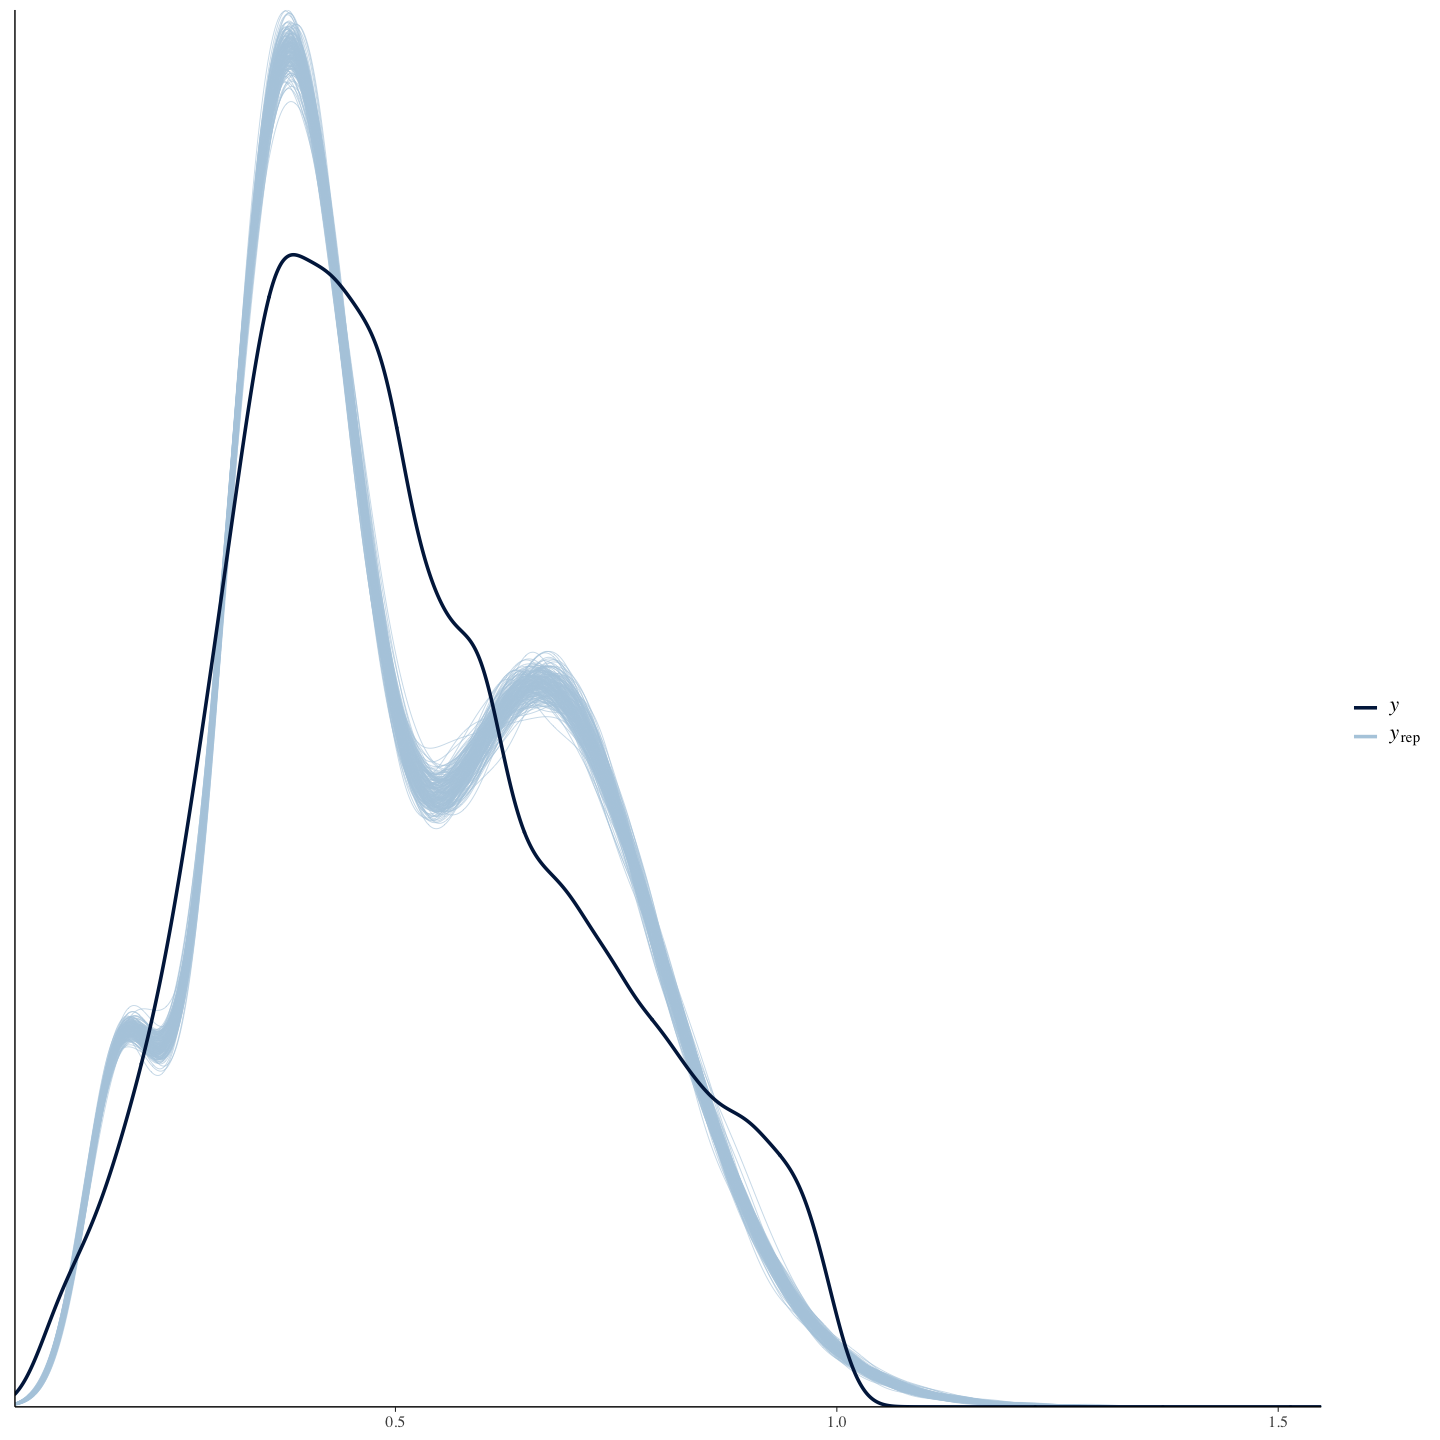

In [233]:
pp_check(fit2,nsamples = 200)

In [237]:
unique(df.ldn.tmp$PricePaidGroup)

[1] (5e+05,1e+06]   (2.5e+05,5e+05] [1e+05,2.5e+05]
5 Levels: [1e+05,2.5e+05] (2.5e+05,5e+05] (5e+05,1e+06] ... (2e+06,5e+06]

In [238]:
newdata.tmp1 <- NULL
newdata.tmp2 <- NULL
newdata <- NULL
for ( i in seq(1,3)){
    print(i)
    newdata.tmp1 <- data.frame("Month" = rep(seq(1,12),10), 
                    "PricePaidGroup" = rep(unique(df.ldn.tmp$PricePaidGroup)[i],120))
    newdata.tmp2 <- rbind(newdata.tmp1,newdata.tmp2)
}
newdata <- newdata.tmp2
head(newdata)

[1] 1
[1] 2
[1] 3


,Month,PricePaidGroup
,<int>,<fct>
1,1,"[1e+05,2.5e+05]"
2,2,"[1e+05,2.5e+05]"
3,3,"[1e+05,2.5e+05]"
4,4,"[1e+05,2.5e+05]"
5,5,"[1e+05,2.5e+05]"
6,6,"[1e+05,2.5e+05]"


In [239]:
preds2 <- predict(fit2, newdata = newdata)

In [240]:

preds_df2 = data.frame(preds2)
preds_df2 <- bind_cols(newdata,preds_df2)
preds_df2 <- aggregate(.~(Month+PricePaidGroup),data=preds_df2,FUN=mean)

df.ldn.tmp.f <- df.ldn.tmp
df.ldn.tmp.f$"Month" <- as.factor(df.ldn.tmp.f$"Month")

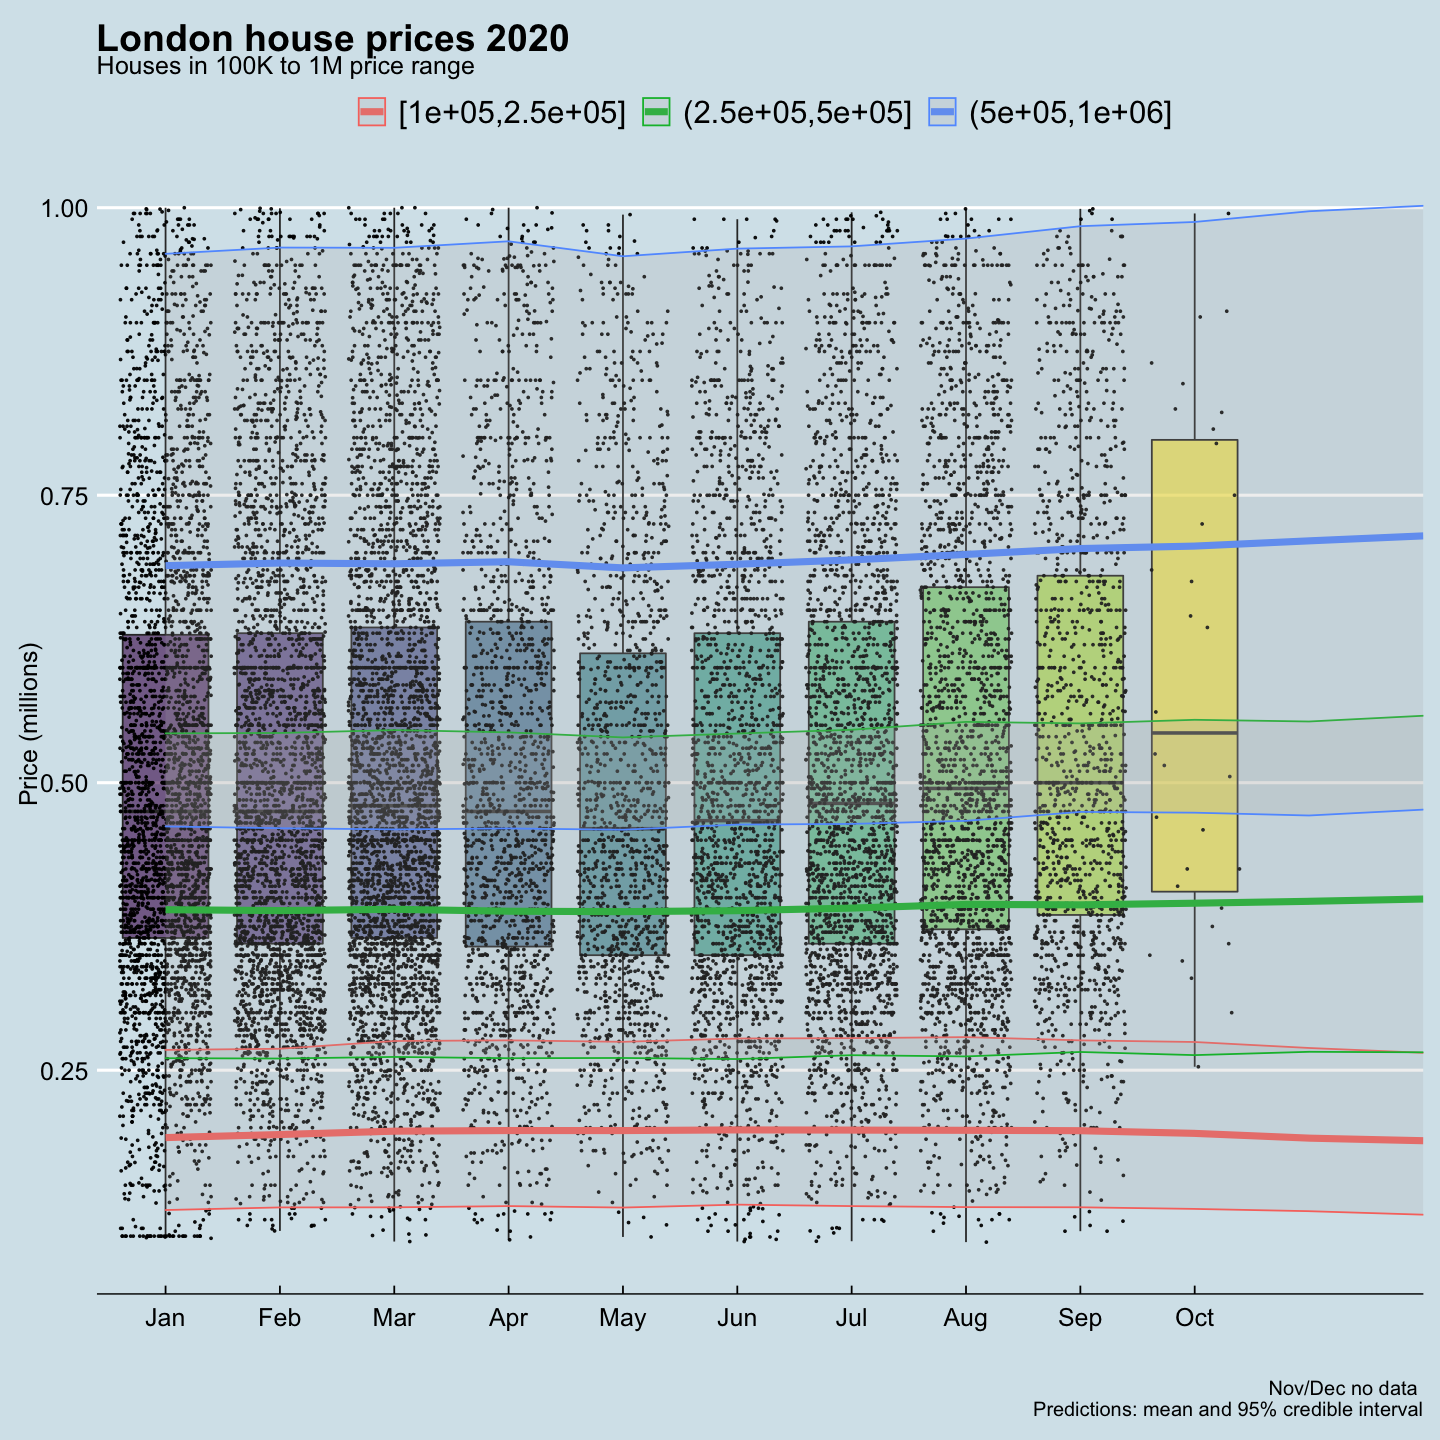

In [242]:
  ggplot() +
    theme_economist() + 
    scale_x_discrete(labels= c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")) +
#     theme(legend.position="none") +
    xlab("Month") + ylab("Price (millions)") +  
    labs(title = "London house prices 2020",
        subtitle = "Houses in 100K to 1M price range",
        caption ="\nNov/Dec no data \nPredictions: mean and 95% credible interval") +
    geom_boxplot(data=df.ldn.tmp.f, aes(x=Month, y=PricePaid, fill=Month),show.legend = FALSE) +
    scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    geom_jitter(data=df.ldn.tmp.f, aes(x=Month, y=PricePaid),color="black", size=0.4, alpha=0.9) +
     theme(text = element_text(size = 20),legend.title = element_blank())  + 
    geom_line(data = preds_df2, aes(y=Estimate, x=Month, group = PricePaidGroup,col=PricePaidGroup), size = 2)   +
     theme(text = element_text(size = 15),legend.title = element_blank()) +
    geom_ribbon(data = preds_df2,
        aes(ymin = Q2.5, ymax = Q97.5,x=Month, col=PricePaidGroup, group = PricePaidGroup), fill = "grey70", alpha = 0.2) +
    xlab("")

In [244]:
newdata.tmp1 <- NULL
newdata.tmp2 <- NULL
newdata <- NULL
for ( i in seq(1,3)){
#     print(i)
    newdata.tmp1 <- data.frame("Month" = rep(seq(1,12),10), 
                    "PricePaidGroup" = rep(unique(df.ldn.tmp$PricePaidGroup)[i],120))
    newdata.tmp2 <- rbind(newdata.tmp1,newdata.tmp2)
}
newdata <- newdata.tmp2
preds2 <- predict(fit2, newdata = newdata)
preds2 = data.frame(preds2)
preds2 <- bind_cols(newdata,preds2)

preds2$sd_lower = preds2$Estimate - (preds2$Estimate - preds2$Q2.5)/sqrt(length(preds2$Estimate))
preds2$sd_upper = preds2$Estimate + ( preds2$Q97.5 -preds2$Estimate)/sqrt(length(preds2$Estimate))

preds_df2 <- aggregate(.~(Month + PricePaidGroup),data=preds2,FUN=mean)
preds_df2$Estimate1 = sort(rep((preds_df2 %>% filter(row_number() %% 12 == 1))$"Estimate",12))

df_grow = data.frame("Month" = preds_df2$"Month", "PricePaidGroup" = preds_df2$"PricePaidGroup",
                    "Growth" = 100*(preds_df2$Estimate - preds_df2$Estimate1)/preds_df2$Estimate,
                    "G_up" = 100*(preds_df2$sd_upper - preds_df2$Estimate1)/preds_df2$Estimate,
                    "G_low" = 100*(preds_df2$sd_lower - preds_df2$Estimate1)/preds_df2$Estimate)

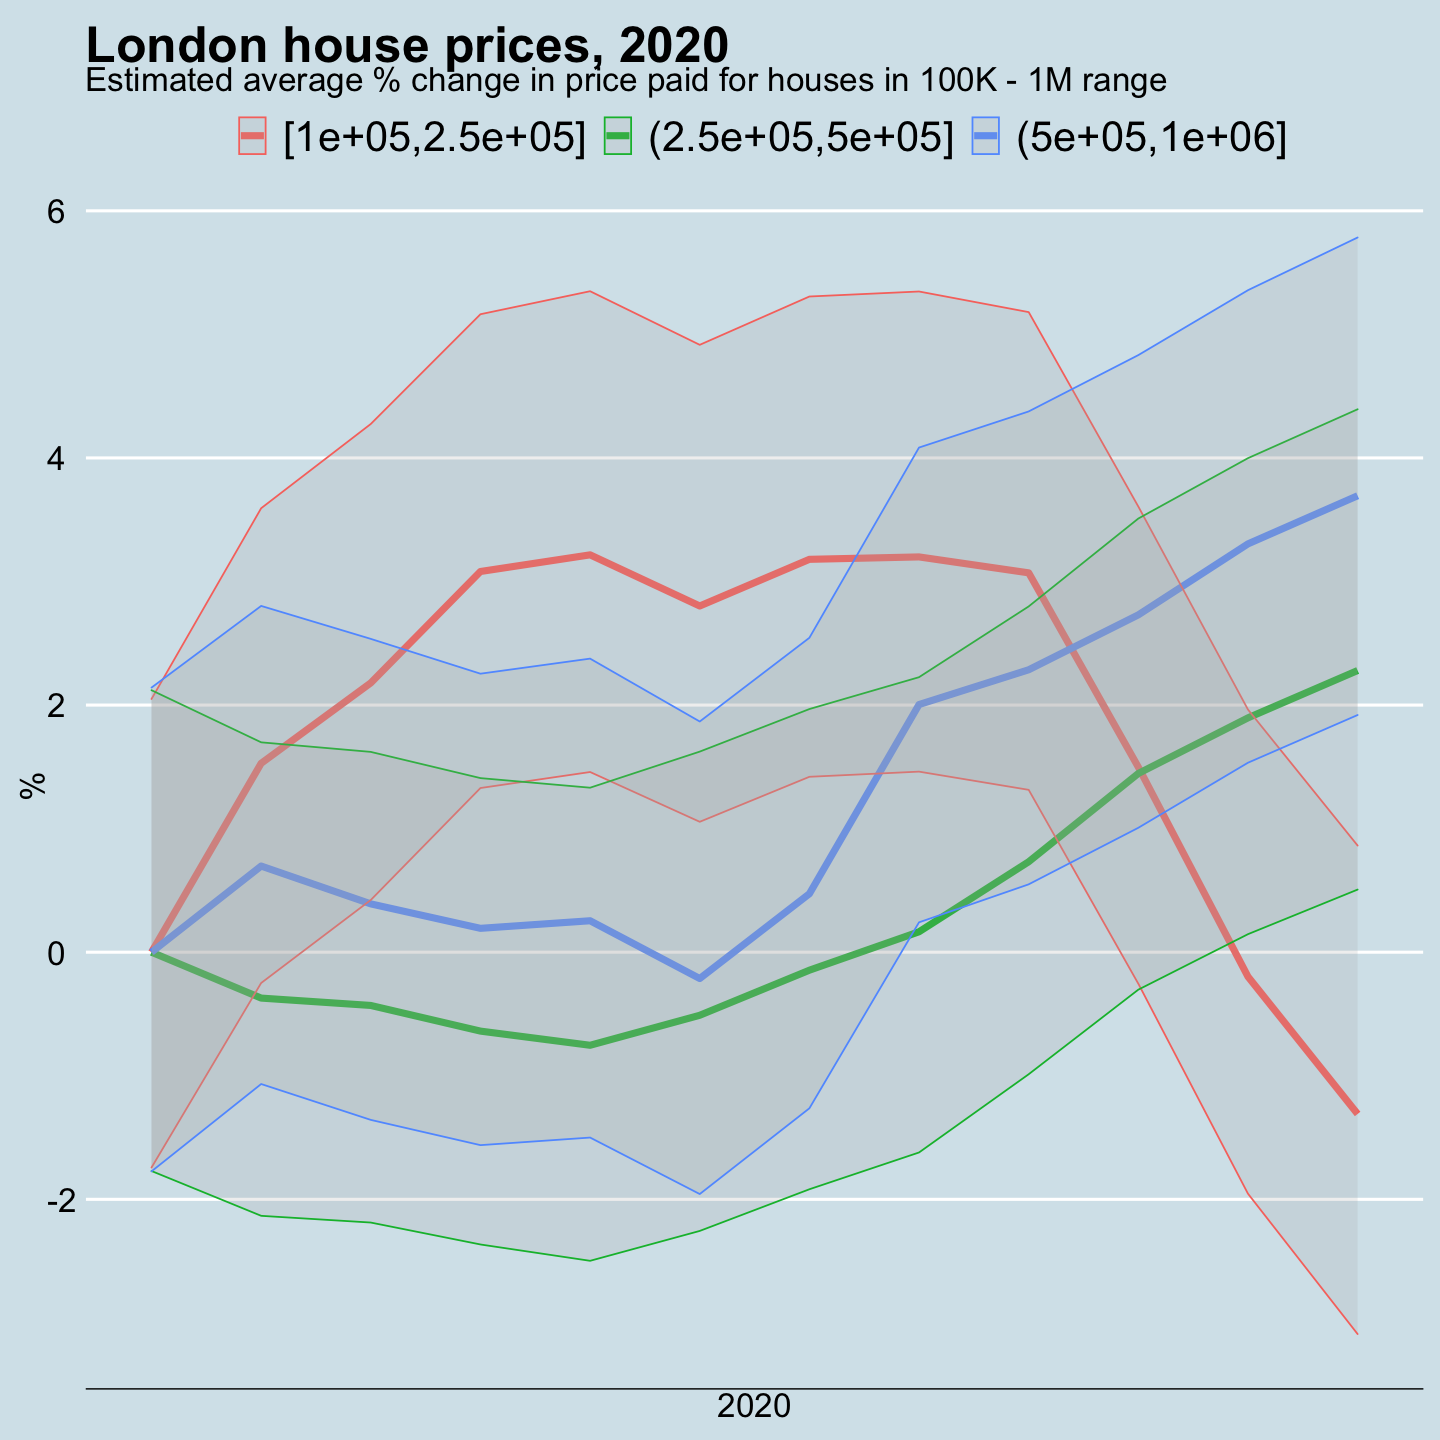

In [245]:
df_grow %>% ggplot() + geom_line(aes(x = Month, y = Growth, group = PricePaidGroup, col = PricePaidGroup),size = 2) +
     geom_ribbon(aes(ymin = G_low, ymax = G_up, x = Month, group = PricePaidGroup, col = PricePaidGroup), fill = "grey70", alpha = 0.2) +
    theme_economist() + 
#     theme(legend.position="none") +
    ylab("%")  +
    labs(title = "London house prices, 2020",
              subtitle = "Estimated average % change in price paid for houses in 100K - 1M range") +
    theme(text = element_text(size = 20),legend.title = element_blank())  + xlab("2020") +
    scale_x_discrete(labels= c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"))